In [1]:
!pip install jcopdl==1.1.1
!pip install gdown

  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12607 sha256=f7e70a9adcccfc4fb03c3447532011d9c40f9f334874b7ae07a5e79f4dd8a958
  Stored in directory: /root/.cache/pip/wheels/06/ce/6a/07bd2e8bea88a0430ef2a1b992aae7162fe7726d1aa1f5b45f
Successfully built jcopdl


In [5]:
!gdown https://drive.google.com/uc?id=1G7VwUtI5eN3dIOdemHgb_SPdrIB2q8pJ

Downloading...
From: https://drive.google.com/uc?id=1G7VwUtI5eN3dIOdemHgb_SPdrIB2q8pJ
To: /content/panorama.zip
25.7MB [00:00, 45.4MB/s]


In [ ]:
!unzip /content/panorama.zip

# Panorama Classification (Multilabel) with MobileNetV2

## Import Library

In [26]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset & Dataloader

In [27]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [28]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [29]:
features, target = next(iter(trainloader))
features.shape

torch.Size([64, 3, 224, 224])

In [30]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

## Arsitektur & Config

In [31]:
from torchvision.models import mobilenet_v2

In [32]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=output_size)
        )
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [33]:
config = set_config({
    'output_size': len(train_set.classes),
    'batch_size': bs,
    'crop_size': crop_size
})

## Fase 1 : Adaptation (lr standard + patience kecil)

## Training Preparation

In [34]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model", early_stop_patience=2)

## Training 

In [36]:
from tqdm.auto import tqdm

In [37]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 0.4974 | Test_cost  = 0.3837 | 




Epoch     2
Train_cost  = 0.3725 | Test_cost  = 0.3318 | 




Epoch     3
Train_cost  = 0.3343 | Test_cost  = 0.2826 | 




Epoch     4
Train_cost  = 0.3062 | Test_cost  = 0.2718 | 




Epoch     5
Train_cost  = 0.2988 | Test_cost  = 0.2582 | 




Epoch     6
Train_cost  = 0.2915 | Test_cost  = 0.2476 | 




Epoch     7
Train_cost  = 0.2822 | Test_cost  = 0.2416 | 




Epoch     8
Train_cost  = 0.2801 | Test_cost  = 0.2353 | 




Epoch     9
Train_cost  = 0.2786 | Test_cost  = 0.2355 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2353




Epoch    10
Train_cost  = 0.2787 | Test_cost  = 0.2349 | 




Epoch    11
Train_cost  = 0.2608 | Test_cost  = 0.2304 | 




Epoch    12
Train_cost  = 0.2533 | Test_cost  = 0.2289 | 




Epoch    13
Train_cost  = 0.2637 | Test_cost  = 0.2232 | 




Epoch    14
Train_cost  = 0.2548 | Test_cost  = 0.2297 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2232




Epoch    15
Train_cost  = 0.2625 | Test_cost  = 0.2230 | 




Epoch    16
Train_cost  = 0.2478 | Test_cost  = 0.2321 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2230




Epoch    17
Train_cost  = 0.2445 | Test_cost  = 0.2148 | 




Epoch    18
Train_cost  = 0.2579 | Test_cost  = 0.2165 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2148




Epoch    19
Train_cost  = 0.2516 | Test_cost  = 0.2190 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2148
==> Execute Early Stopping at epoch: 19 | Best test_cost: 0.2148
==> Best model is saved at model


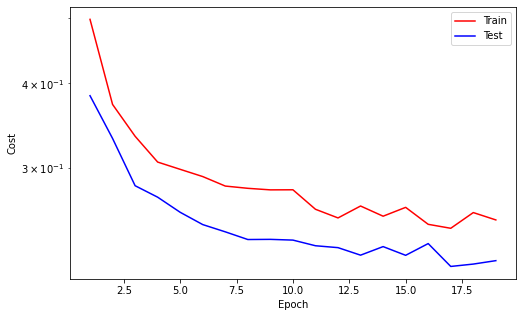

In [27]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Fase 2 : Fine Tuning (lr dikecilin + patience ditambah)

In [28]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-05)
callback.reset_early_stop()
callback.early_stop_patience = 6



Epoch    20
Train_cost  = 0.2350 | Test_cost  = 0.2083 | 


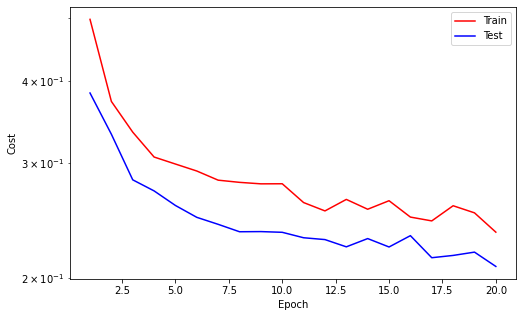



Epoch    21
Train_cost  = 0.2255 | Test_cost  = 0.1955 | 




Epoch    22
Train_cost  = 0.2156 | Test_cost  = 0.1908 | 




Epoch    23
Train_cost  = 0.2127 | Test_cost  = 0.1897 | 




Epoch    24
Train_cost  = 0.2065 | Test_cost  = 0.1871 | 




Epoch    25
Train_cost  = 0.2042 | Test_cost  = 0.1865 | 




Epoch    26
Train_cost  = 0.1946 | Test_cost  = 0.1788 | 




Epoch    27
Train_cost  = 0.1886 | Test_cost  = 0.1750 | 




Epoch    28
Train_cost  = 0.1933 | Test_cost  = 0.1753 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1750




Epoch    29
Train_cost  = 0.1890 | Test_cost  = 0.1712 | 




Epoch    30
Train_cost  = 0.1837 | Test_cost  = 0.1668 | 




Epoch    31
Train_cost  = 0.1834 | Test_cost  = 0.1652 | 




Epoch    32
Train_cost  = 0.1751 | Test_cost  = 0.1753 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1652




Epoch    33
Train_cost  = 0.1695 | Test_cost  = 0.1715 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1652




Epoch    34
Train_cost  = 0.1710 | Test_cost  = 0.1654 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1652




Epoch    35
Train_cost  = 0.1727 | Test_cost  = 0.1647 | 




Epoch    36
Train_cost  = 0.1647 | Test_cost  = 0.1630 | 




Epoch    37
Train_cost  = 0.1577 | Test_cost  = 0.1626 | 




Epoch    38
Train_cost  = 0.1667 | Test_cost  = 0.1611 | 




Epoch    39
Train_cost  = 0.1658 | Test_cost  = 0.1558 | 




Epoch    40
Train_cost  = 0.1590 | Test_cost  = 0.1554 | 


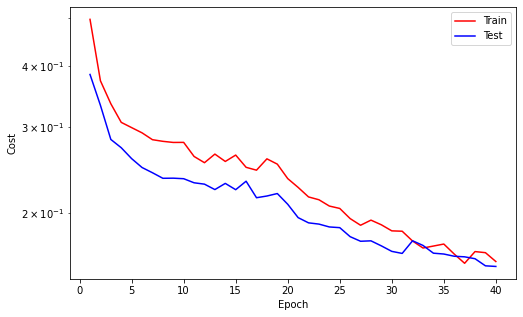



Epoch    41
Train_cost  = 0.1583 | Test_cost  = 0.1643 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1554




Epoch    42
Train_cost  = 0.1573 | Test_cost  = 0.1555 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1554




Epoch    43
Train_cost  = 0.1508 | Test_cost  = 0.1582 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1554




Epoch    44
Train_cost  = 0.1567 | Test_cost  = 0.1540 | 




Epoch    45
Train_cost  = 0.1505 | Test_cost  = 0.1499 | 




Epoch    46
Train_cost  = 0.1456 | Test_cost  = 0.1520 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1499




Epoch    47
Train_cost  = 0.1461 | Test_cost  = 0.1556 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1499




Epoch    48
Train_cost  = 0.1474 | Test_cost  = 0.1517 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1499




Epoch    49
Train_cost  = 0.1472 | Test_cost  = 0.1514 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1499




Epoch    50
Train_cost  = 0.1394 | Test_cost  = 0.1552 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1499
==> Execute Early Stopping at epoch: 50 | Best test_cost: 0.1499
==> Best model is saved at model


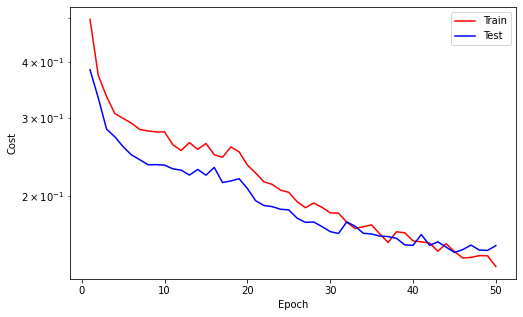

In [29]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Predict

In [35]:
features, target = next(iter(testloader))
features, target = features.to(device), target.to(device)

In [36]:
with torch.no_grad():
    model.eval()
    output = model(features)
    y_pred = (output > 0.5).to(torch.float64)

In [37]:
y_pred

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1

## Sanity Check

In [38]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img 

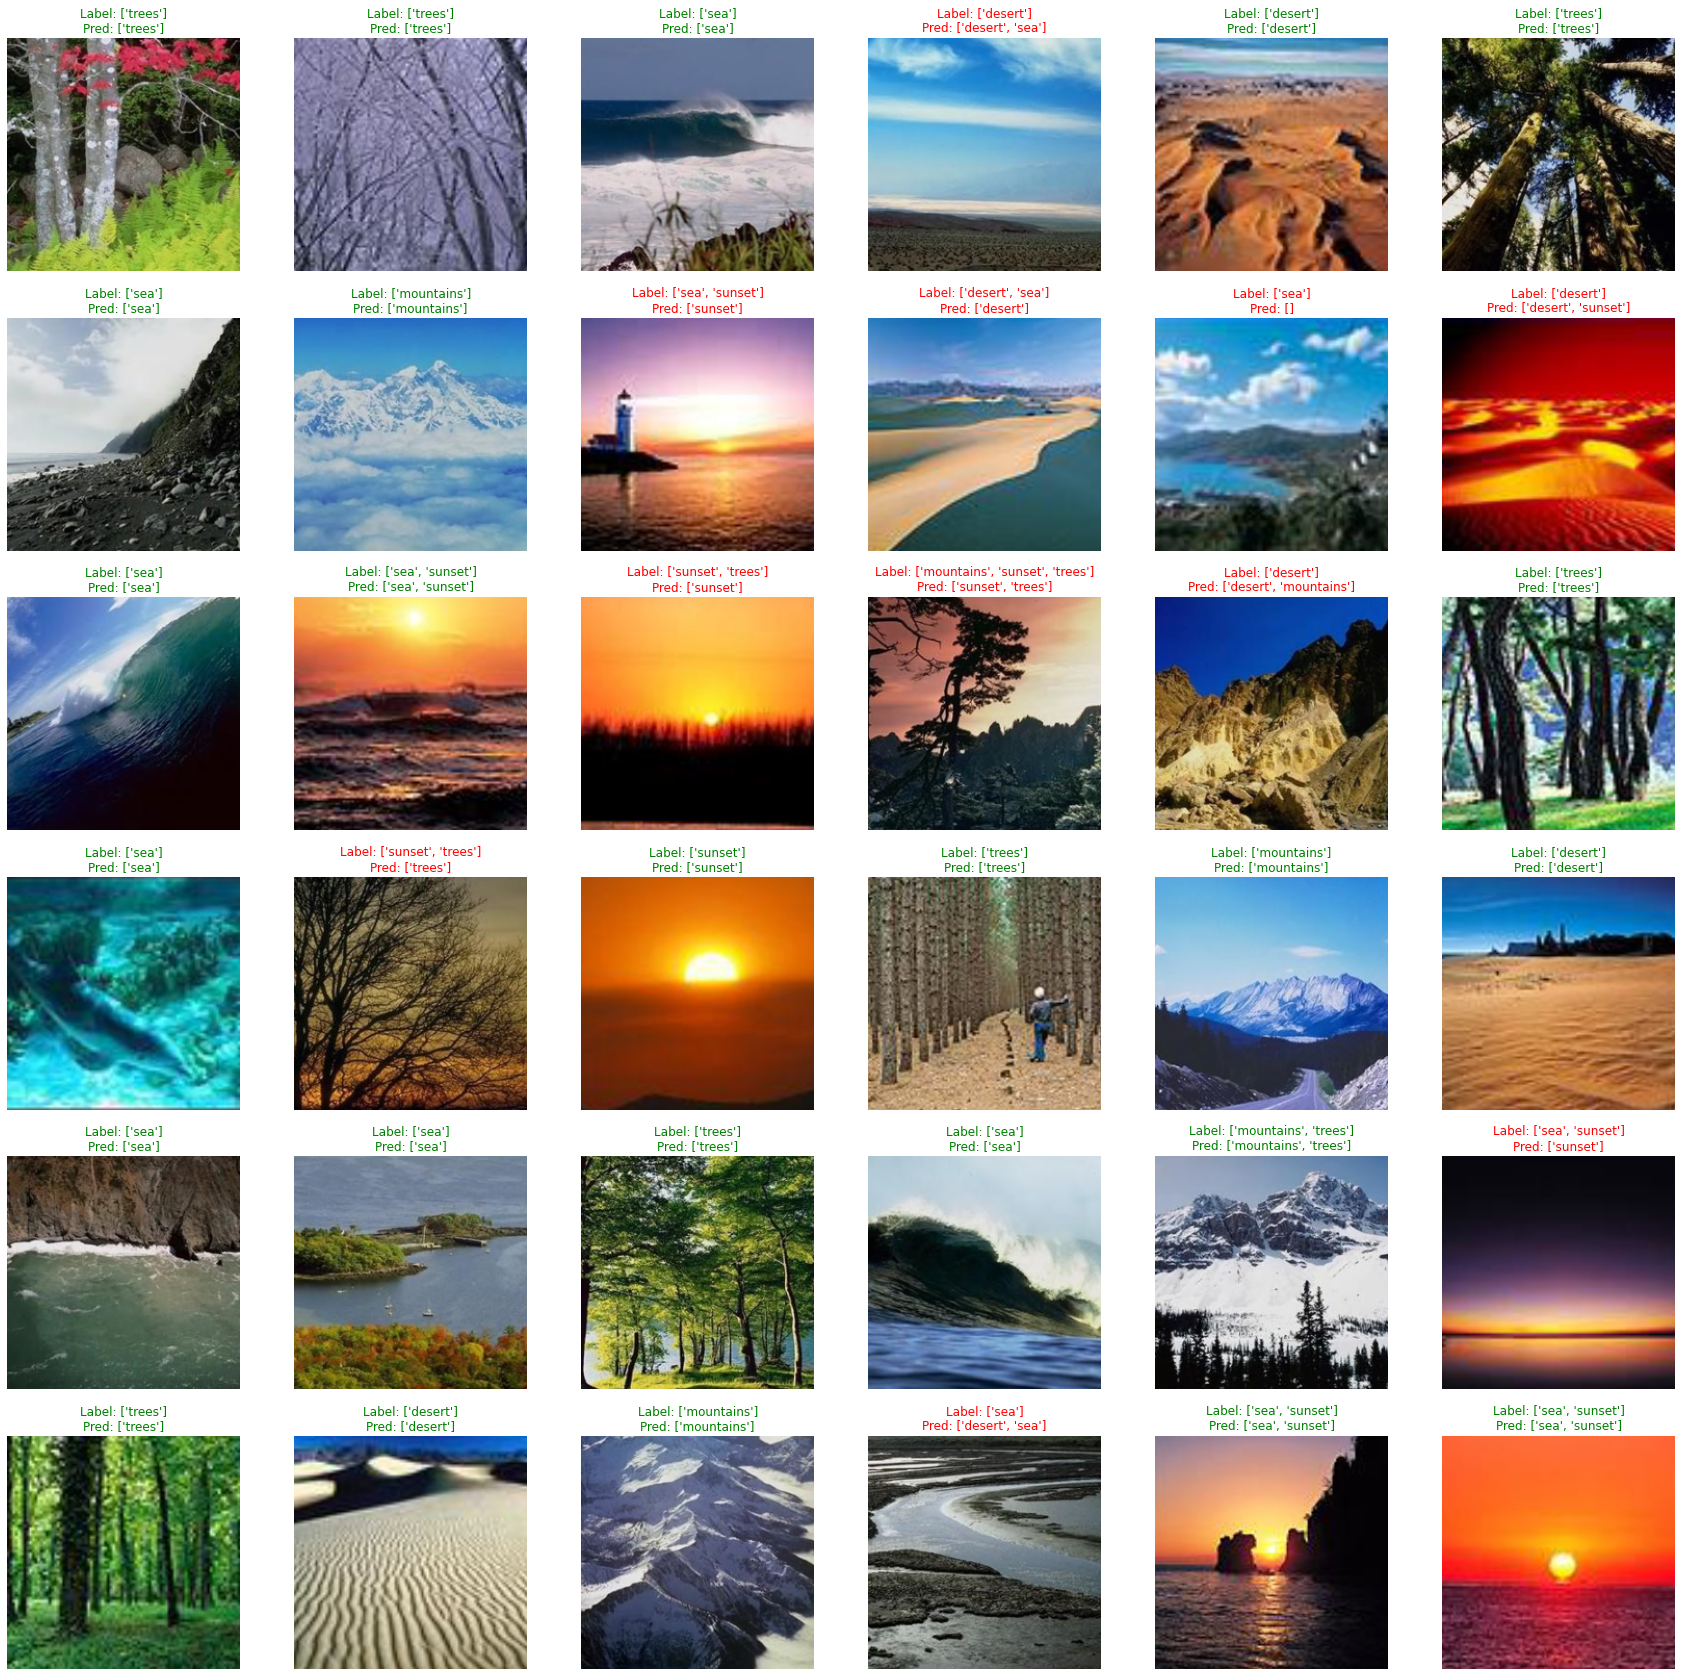

In [39]:
fig, axes = plt.subplots(6, 6, figsize=(30, 30))
for img, label, pred, ax in zip(features, target, y_pred, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {'color': 'r'} if (pred != label).any() else {'color': 'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    
    ax.set_title(f'Label: {label}\nPred: {pred}', fontdict=font);
    ax.axis('off');

In [40]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/weights_best.pth (deflated 8%)
  adding: content/model/logs.pth (deflated 24%)
  adding: content/model/configs.pth (deflated 51%)
  adding: content/model/weights_50.pth (deflated 8%)


## Evaluation

In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, hamming_loss, multilabel_confusion_matrix

In [ ]:
bs = 500

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [ ]:
features, target = next(iter(testloader))
features, target = features.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(features)
    y_pred = (output > 0.5).to(torch.float64)
    y_pred = y_pred.to('cpu').numpy()
    target = target.to('cpu').numpy()

In [ ]:
print(classification_report(target, y_pred, target_names=label2cat))

In [ ]:
multilabel_confusion_matrix(target, y_pred)

In [ ]:
print('Accuracy :', accuracy_score(target, y_pred))
print('F1 Score :', f1_score(target, y_pred, average='samples'))
print('Hamming Loss :', hamming_loss(target, y_pred))